In [1]:
#import intel extension for scikit learnimport os
from sklearnex import patch_sklearn,unpatch_sklearn
from daal4py.oneapi import sycl_context
patch_sklearn(global_patch=True)


Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn



In [3]:
#read the chipset data and finding the missing datas
df = pd.read_csv('chip_dataset.csv')
df.isnull().sum()

Unnamed: 0                  0
Product                     0
Type                        0
Release Date                0
Process Size (nm)           9
TDP (W)                   626
Die Size (mm^2)           715
Transistors (million)     711
Freq (MHz)                  0
Foundry                     0
Vendor                      0
FP16 GFLOPS              4318
FP32 GFLOPS              2906
FP64 GFLOPS              3548
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4854 entries, 0 to 4853
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4854 non-null   int64  
 1   Product                4854 non-null   object 
 2   Type                   4854 non-null   object 
 3   Release Date           4854 non-null   object 
 4   Process Size (nm)      4845 non-null   float64
 5   TDP (W)                4228 non-null   float64
 6   Die Size (mm^2)        4139 non-null   float64
 7   Transistors (million)  4143 non-null   float64
 8   Freq (MHz)             4854 non-null   float64
 9   Foundry                4854 non-null   object 
 10  Vendor                 4854 non-null   object 
 11  FP16 GFLOPS            536 non-null    float64
 12  FP32 GFLOPS            1948 non-null   float64
 13  FP64 GFLOPS            1306 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 531.0+ 

dropping uneeded columns form the dataframe for better vizual

becase we are looking to compare GPUs and the dataset contains both we will delete the cpu records in the dataset

In [5]:
for i in range(len(df)):
    if (df["Type"][i]=="CPU"):
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)

#verifying the changes
df["Type"].unique()

array(['GPU'], dtype=object)

unnamed:0 is the default indexing column in the dataset, dropped as there is a index in the df already

FP16 (half-precision floating-point format) uses 16 bits to represent a floating-point number, with I bit for the sign, 5 bits for the exponent,
and 10 bits for the mantissa. FP16 provides less precision than FP32r but it requires less memory and can be faster to compute. However,
some machine leaming models may not perform well with the reduced precision of FP16.

FP32 (single-precision floating-point format) is a commonly used format for numerical computations in machine leaming because it provides
a good balance between precision and performance. FP32 uses 32 bits to represent a floating-point number, with 1 bit for the signr 8 bits for
the exponent and 23 bits for the mantissa.

FP64 (double-precision floating-point format) uses 64 bits to represent a floating-point number, with I bit for the sign, I I bits for the
exponent, and 52 bits for the mantissa. FP64 provides higher precision than FP32, but it requires more memory and can be slower to
compute.

In general, the choice of floating-point format depends on the specific requirements of the machine learning model and the hardware being
used. FP32 is a good default choice for most machine leaming applications, but FP16 or FP64 may be more appropriate in certain cases
where precision or performance is a critical factor.

becase 32bit most common and it havbe the least numbe of missing values we use that

In [6]:
df.drop("FP16 GFLOPS", axis=1, inplace=True)
df.drop("FP64 GFLOPS", axis=1, inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("Type", axis=1, inplace=True)


In [7]:
df.isnull().sum()

Product                    0
Release Date               0
Process Size (nm)          9
TDP (W)                  626
Die Size (mm^2)          183
Transistors (million)    194
Freq (MHz)                 0
Foundry                    0
Vendor                     0
FP32 GFLOPS              714
dtype: int64

Because we are trying to predict the score of FP32, it is the best if we remove any row with this column missing

In [8]:
for i in range(len(df)):
    if pd.isnull(df["FP32 GFLOPS"][i]):
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.isnull().sum()

Product                    0
Release Date               0
Process Size (nm)          4
TDP (W)                  203
Die Size (mm^2)          115
Transistors (million)    137
Freq (MHz)                 0
Foundry                    0
Vendor                     0
FP32 GFLOPS                0
dtype: int64

In [10]:
df.shape

(1948, 10)

In [11]:
print((4+203+115+137)/1948)

0.23562628336755648


Removeing the rows with any column missing as they would make up at most 23% of the dataset and thus would not make a very big difference

In [12]:
#finding missing rows in the TDP (W) column
for i in range(len(df)):
    if pd.isnull(df["TDP (W)"][i]):
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)
#finding missing rows in the Die Size (mm^2) column
for i in range(len(df)):
    if pd.isnull(df["Die Size (mm^2)"][i]):
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)
#finding missing rows in the Transistors (million) column
for i in range(len(df)):
    if pd.isnull(df["Transistors (million)"][i]):
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)
#finding missing rows in the Process Size (nm) column
for i in range(len(df)):
    if pd.isnull(df["Process Size (nm)"][i]):
        df.drop(i, inplace=True)
#verifying the changes

df.dropna(subset=['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Process Size (nm)'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

Product                  0
Release Date             0
Process Size (nm)        0
TDP (W)                  0
Die Size (mm^2)          0
Transistors (million)    0
Freq (MHz)               0
Foundry                  0
Vendor                   0
FP32 GFLOPS              0
dtype: int64

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Product                1562 non-null   object        
 1   Release Date           1562 non-null   datetime64[ns]
 2   Process Size (nm)      1562 non-null   float64       
 3   TDP (W)                1562 non-null   float64       
 4   Die Size (mm^2)        1562 non-null   float64       
 5   Transistors (million)  1562 non-null   float64       
 6   Freq (MHz)             1562 non-null   float64       
 7   Foundry                1562 non-null   object        
 8   Vendor                 1562 non-null   object        
 9   FP32 GFLOPS            1562 non-null   float64       
 10  Release Year           1562 non-null   int64         
 11  die_dens               1562 non-null   float64       
 12  transistor_freq        1562 non-null   float64       
dtypes: 

Release date matters as different generations of graphics cards will have different focuses and improvments in performance and making the date a variable column will help the machine in finding the pattern better

date is unclean as some are missing, thisis finding the missing data and comparingit to the total size, since it is only 40 out of 1570 rows we can just delete them and they will not have a major effect on the dataset

In [13]:
df["Release Date"].shape

(1610,)

In [14]:
#remove rows where they equal to NaT in Release Date
df = df.drop(df[df['Release Date'] == 'NaT'].index)

In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
df["Release Date"].shape

(1570,)

becase the excate date is not really important, and it does not matter as much as the generation the gpu is in which is better determined by the year, we will bin the date by year

In [17]:
#splicing the release date column to get the year
df['Release Date']=pd.to_datetime(df['Release Date'])
df['Release Year']=df['Release Date'].dt.year
print (df['Release Year'])

0       2019
1       2008
2       2007
3       2008
4       2012
        ... 
1565    2019
1566    2019
1567    2010
1568    2011
1569    2010
Name: Release Year, Length: 1570, dtype: int64


however since year is a very big number it may cause a problem where the machine puch too much pirotiyt to it and thus it wuld be better to instead fint eh differeence bwtwwen teh eareliest model and the current moel

In [19]:
df.describe()

,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP32 GFLOPS,Release Year
count,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000
mean,34.471338,97.926752,231.335032,3463.352229,791.324204,2294.756841,2012.993631
std,18.237076,98.923951,162.169579,5686.993083,303.673389,4089.966739,3.823707
min,7.000000,5.000000,56.000000,123.000000,133.000000,12.800000,2005.000000
25%,22.000000,31.000000,116.000000,585.000000,589.000000,250.075000,2010.000000
50%,28.000000,65.000000,169.000000,1351.500000,730.000000,722.300000,2013.000000
75%,40.000000,146.750000,314.000000,4313.000000,967.000000,2368.000000,2016.000000
max,90.000000,900.000000,826.000000,54200.000000,2321.000000,40000.000000,2021.000000


In [22]:
for i in range (len(df)):
    cYear = df['Release Year'][i]
    df['Release Year'][i] =cYear - 2005


C:\Users\Mingg\AppData\Local\Temp\ipykernel_31280\831671634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Release Year'][i] =cYear - 2005


In [23]:
df.describe()

,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP32 GFLOPS,Release Year
count,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000
mean,34.471338,97.926752,231.335032,3463.352229,791.324204,2294.756841,7.993631
std,18.237076,98.923951,162.169579,5686.993083,303.673389,4089.966739,3.823707
min,7.000000,5.000000,56.000000,123.000000,133.000000,12.800000,0.000000
25%,22.000000,31.000000,116.000000,585.000000,589.000000,250.075000,5.000000
50%,28.000000,65.000000,169.000000,1351.500000,730.000000,722.300000,8.000000
75%,40.000000,146.750000,314.000000,4313.000000,967.000000,2368.000000,11.000000
max,90.000000,900.000000,826.000000,54200.000000,2321.000000,40000.000000,16.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Product                1570 non-null   object        
 1   Release Date           1570 non-null   datetime64[ns]
 2   Process Size (nm)      1570 non-null   float64       
 3   TDP (W)                1570 non-null   float64       
 4   Die Size (mm^2)        1570 non-null   float64       
 5   Transistors (million)  1570 non-null   float64       
 6   Freq (MHz)             1570 non-null   float64       
 7   Foundry                1570 non-null   object        
 8   Vendor                 1570 non-null   object        
 9   FP32 GFLOPS            1570 non-null   float64       
 10  Release Year           1570 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 135.0+ KB


In [ ]:
# #one hot encoding on vendor and foundry
# df = pd.get_dummies(df, columns=['Foundry'])

# #verifying the changes
# df.head()

# #exporting the dataset
# df.to_csv('cleaned_chip_dataset4.csv', index=False)

plotting data to see the trends

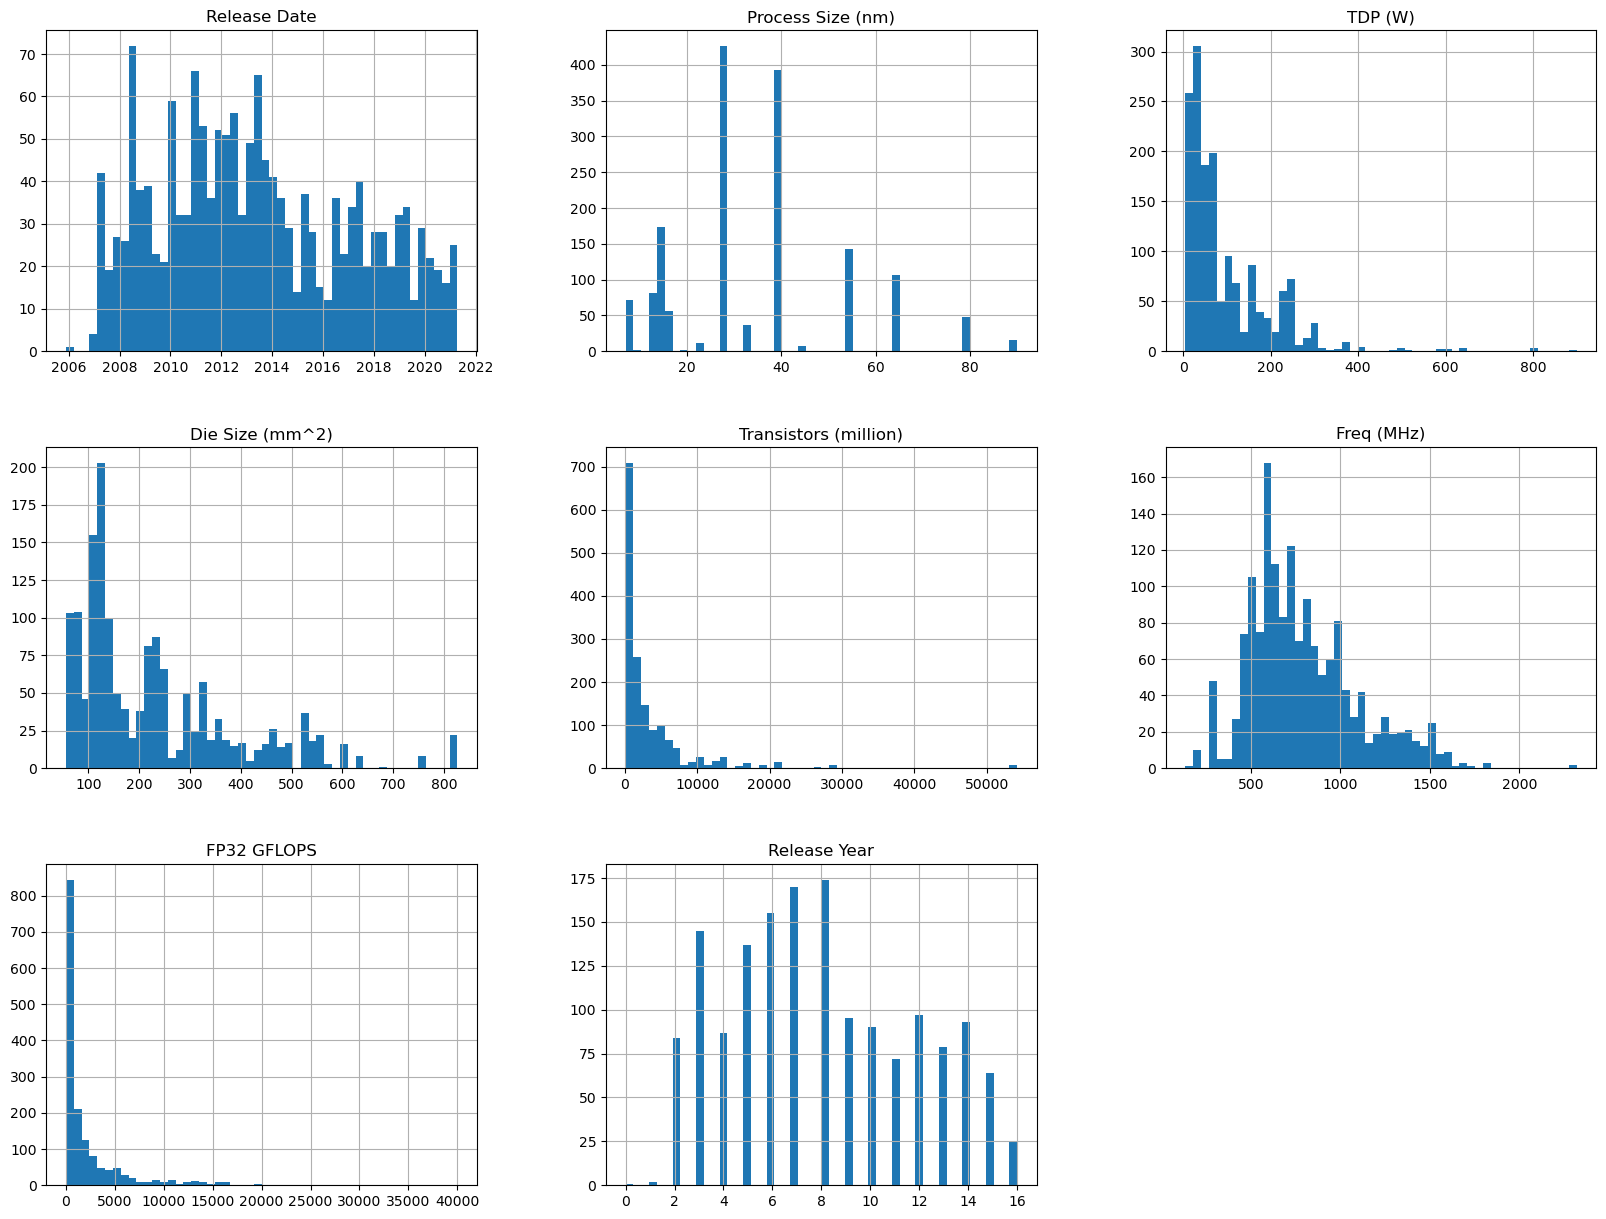

In [25]:
#plot histogram of the data to look at the distribution of the data
df.hist(bins=50, figsize=(20,15))
plt.show()


C:\Users\Mingg\AppData\Local\Temp\ipykernel_31280\2479858392.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


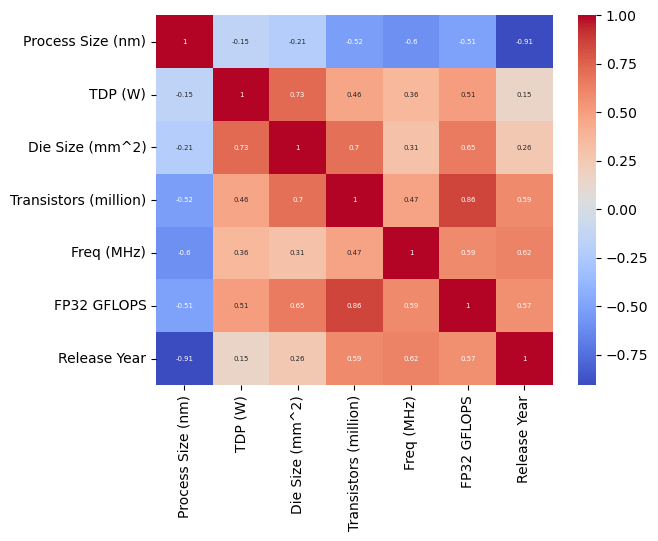

In [26]:
# Compute the correlation matrix
corr = df.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'size':5},)
plt.show()

In [27]:
corr

,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP32 GFLOPS,Release Year
Process Size (nm),1.000000,-0.152637,-0.207626,-0.523064,-0.596955,-0.507674,-0.906891
TDP (W),-0.152637,1.000000,0.731800,0.464234,0.362845,0.506669,0.152116
Die Size (mm^2),-0.207626,0.731800,1.000000,0.695322,0.305939,0.652665,0.255521
Transistors (million),-0.523064,0.464234,0.695322,1.000000,0.474345,0.857460,0.591512
Freq (MHz),-0.596955,0.362845,0.305939,0.474345,1.000000,0.593622,0.623010
FP32 GFLOPS,-0.507674,0.506669,0.652665,0.857460,0.593622,1.000000,0.570912
Release Year,-0.906891,0.152116,0.255521,0.591512,0.623010,0.570912,1.000000


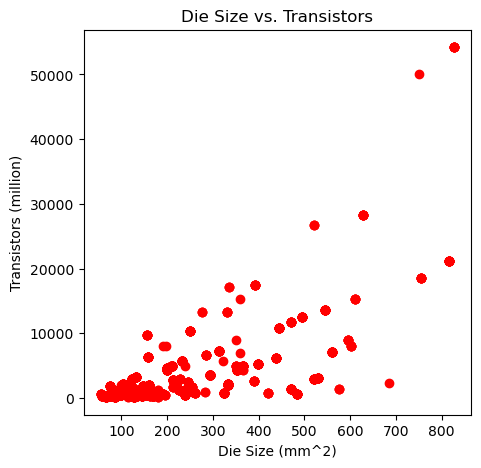

In [28]:
#plotting the relationship between the die size and the number of transistors
plt.figure(figsize=(5,5))
plt.scatter(df['Die Size (mm^2)'], df['Transistors (million)'], color='red')
plt.title('Die Size vs. Transistors')
plt.xlabel('Die Size (mm^2)')
plt.ylabel('Transistors (million)')
plt.show()

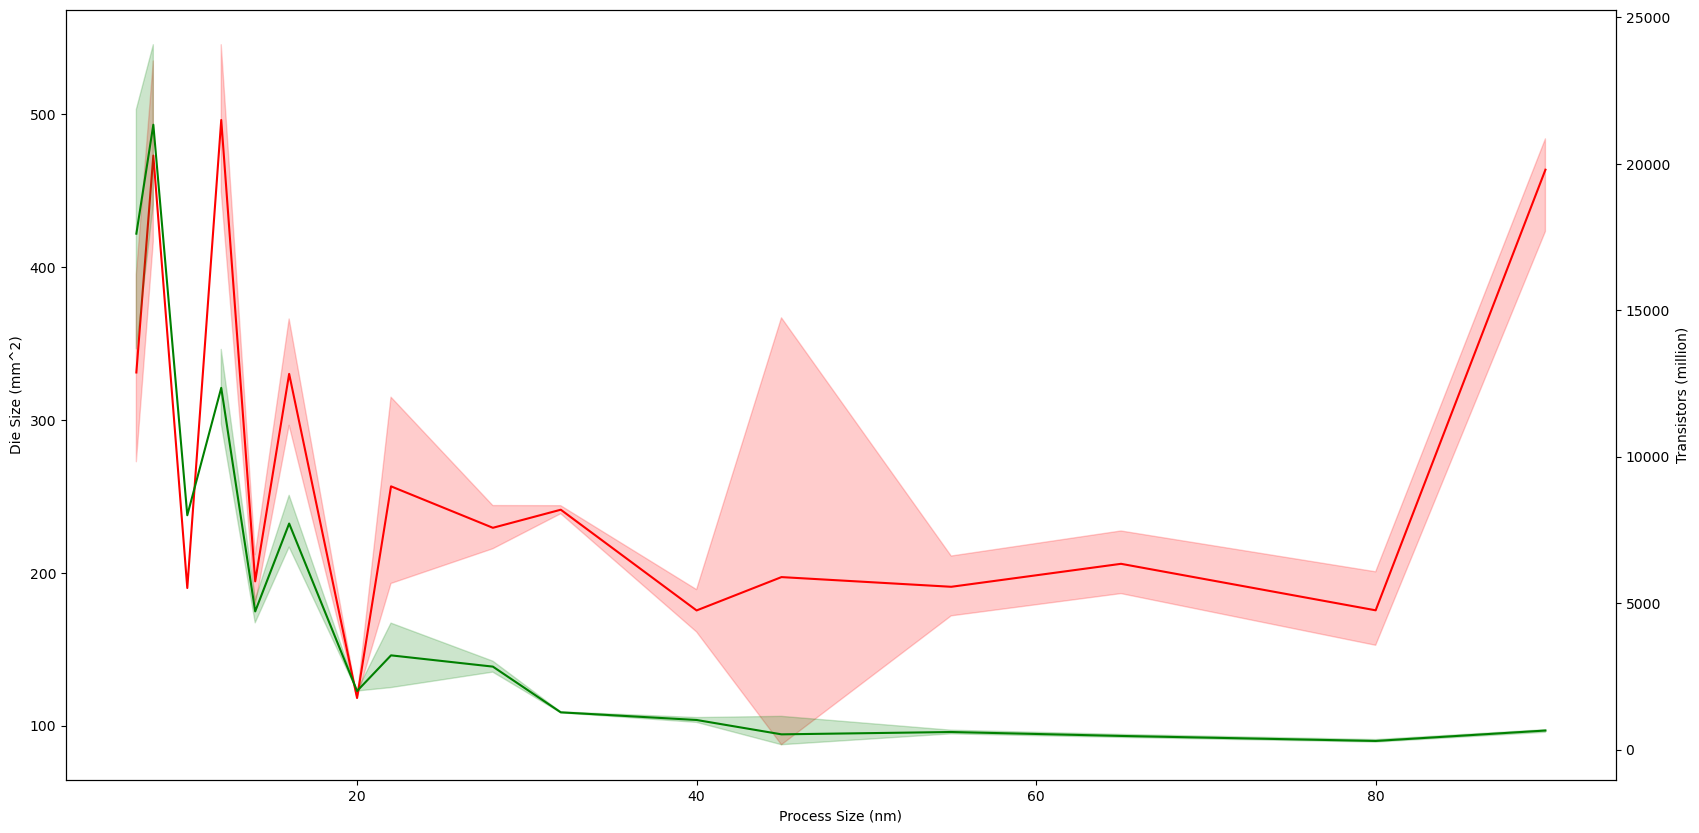

In [ ]:
#dual axis plot for apparent temperature, bike count and month
plt.figure(figsize=(20,10))
ax1 = sns.lineplot(x=df["Process Size (nm)"], y=df["Die Size (mm^2)"], color="r")
ax2 = ax1.twinx()
ax2 = sns.lineplot(x=df["Process Size (nm)"], y=df["Transistors (million)"], color="g")
plt.show()

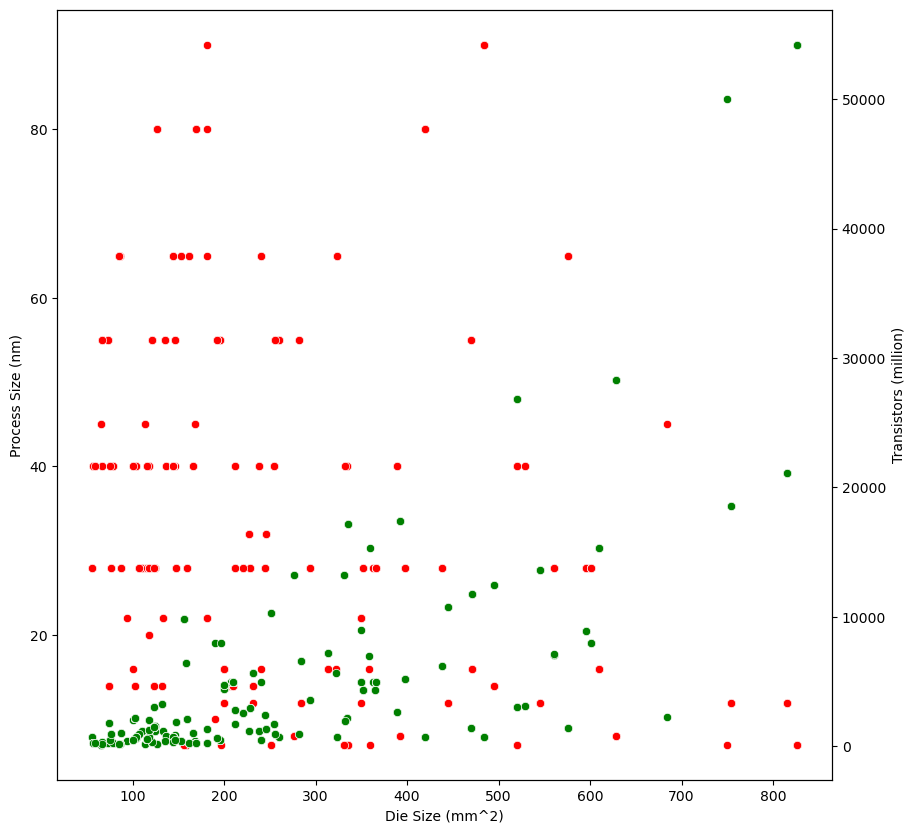

In [29]:
#dual axis plot for apparent temperature, bike count and month
plt.figure(figsize=(10,10))
ax1 = sns.scatterplot(x=df["Die Size (mm^2)"], y=df["Process Size (nm)"], color="r")
ax2 = ax1.twinx()
ax2 = sns.scatterplot(x=df["Die Size (mm^2)"], y=df["Transistors (million)"], color="g")
plt.show()

to better capture the relationship between the die size and transistor size, i devericed a new column called die densiy which is measuered by how many million transistors there are per mm^2 of a gpu core

In [30]:
#creating a new column in the dataframe that combines transistor count and freqency by mulplying them together
df['die_dens'] = (df['Transistors (million)'])/(df['Die Size (mm^2)'])

Text(0.5, 1.0, 'Transistor Density vs 32FP GFLOPS')

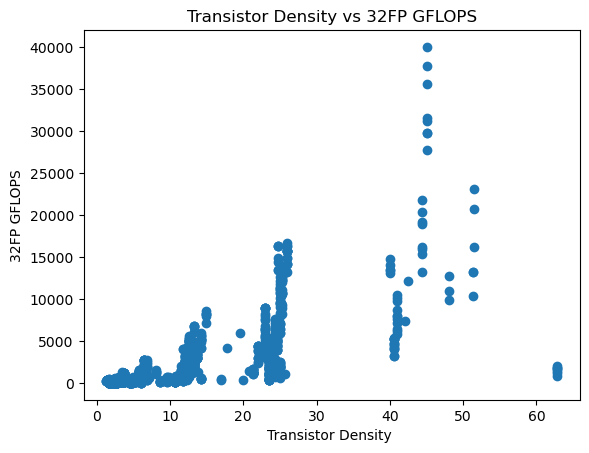

In [103]:
plt.scatter(y=df["FP32 GFLOPS"],x=df["die_dens"])
plt.xlabel('Transistor Density ')
plt.ylabel('32FP GFLOPS')
plt.title('Transistor Density vs 32FP GFLOPS')

Text(0, 0.5, 'FP32 GFLOPS')

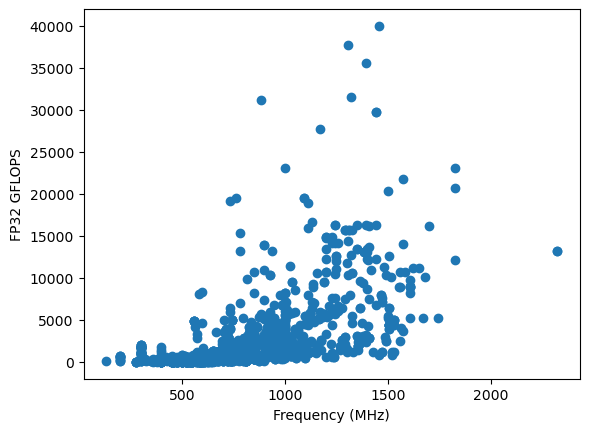

In [35]:
plt.scatter(x=df["Freq (MHz)"],y=df["FP32 GFLOPS"])

plt.xlabel('Frequency (MHz)')
plt.ylabel('FP32 GFLOPS')


Text(0, 0.5, '32FP GFLOPS')

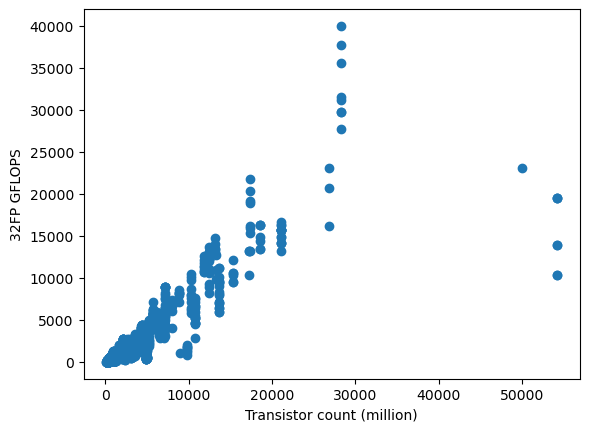

In [33]:
plt.scatter(y=df["FP32 GFLOPS"],x=df["Transistors (million)"])
plt.xlabel('Transistor count (million)')
plt.ylabel('32FP GFLOPS')


In [36]:
#creating a new column in the dataframe that combines transistor count and freqency by mulplying them together
df['transistor_freq'] = (df['Transistors (million)']**0.5) * (df['Freq (MHz)'])


Text(0, 0.5, '32FP GFLOPS')

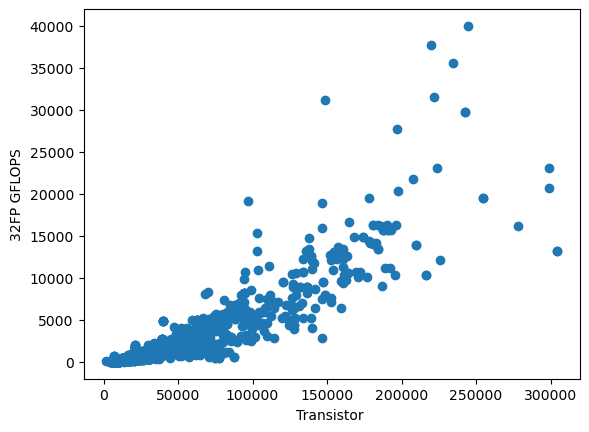

In [37]:
plt.scatter(y=df["FP32 GFLOPS"],x=df["transistor_freq"])
plt.xlabel('Transistor ')
plt.ylabel('32FP GFLOPS')

much more linear relationship between the two values

<Axes: xlabel='transistor_freq', ylabel='FP32 GFLOPS'>

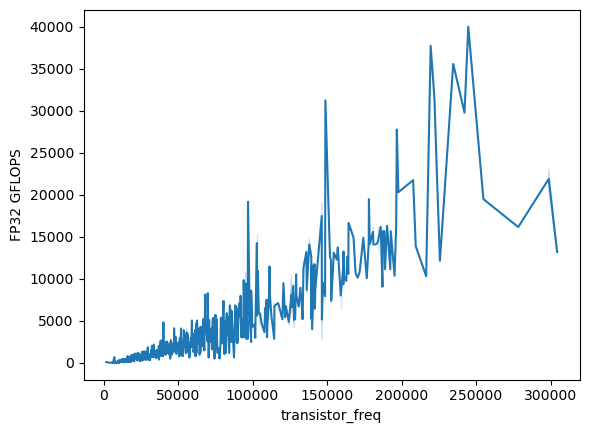

In [38]:
sns.lineplot(x=df["transistor_freq"],y=df["FP32 GFLOPS"])

C:\Users\Mingg\AppData\Local\Temp\ipykernel_31280\2479858392.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


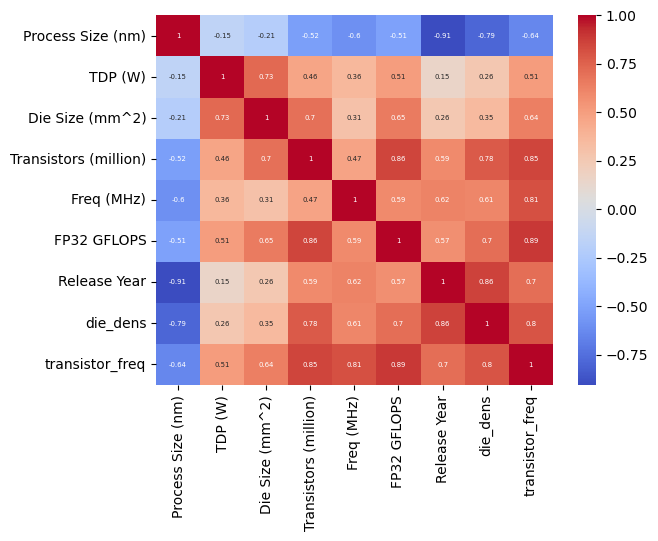

In [39]:
# Compute the correlation matrix
corr = df.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'size':5},)
plt.show()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Product                1570 non-null   object        
 1   Release Date           1570 non-null   datetime64[ns]
 2   Process Size (nm)      1570 non-null   float64       
 3   TDP (W)                1570 non-null   float64       
 4   Die Size (mm^2)        1570 non-null   float64       
 5   Transistors (million)  1570 non-null   float64       
 6   Freq (MHz)             1570 non-null   float64       
 7   Foundry                1570 non-null   object        
 8   Vendor                 1570 non-null   object        
 9   FP32 GFLOPS            1570 non-null   float64       
 10  Release Year           1570 non-null   int64         
 11  die_dens               1570 non-null   float64       
 12  transistor_freq        1570 non-null   float64       
dtypes: 

In [41]:
#remove rows where they equal to NaT in Release Date
df = df.drop(df[df['Transistors (million)'] > 40000].index)
df.reset_index(drop=True, inplace=True)

In [43]:
X = df.drop(["FP32 GFLOPS","Product","Release Date","Vendor","Foundry",'Process Size (nm)'], axis=1)
y = df["FP32 GFLOPS"]
print(X.columns)

Index(['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)',
       'Release Year', 'die_dens', 'transistor_freq'],
      dtype='object')


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor
#import mean_squared_error from sklearn
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error


#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2202588)

#creating a list of models
models = [
    LinearRegression(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    SVR(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    GaussianProcessRegressor(),
    RANSACRegressor(),
    HuberRegressor(),
    SGDRegressor(),
    PassiveAggressiveRegressor(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    Lars(),
    LassoLars(),
    OrthogonalMatchingPursuit(),
    BayesianRidge(),
    XGBRegressor()
]

kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)

#testing using cross validation to find the best model
#for models in models:
#    model = models
#    score = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='mean_absolute_error')
#    print(models)
#    print('score: {:.4f}'.format(score.mean()))
#    print('std: {:.4f}'.format(score.std()))
#    print('\n')

for model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print(model.__class__.__name__)
    print('Training mean absolute error: {:.4f}'.format(mae_train))
    print('Validation mean absolute error: {:.4f}'.format(mae_test))
    print('\n')


LinearRegression
Training mean absolute error: 618.4929
Validation mean absolute error: 618.0155


RandomForestRegressor
Training mean absolute error: 109.6384
Validation mean absolute error: 314.2195


DecisionTreeRegressor
Training mean absolute error: 18.0442
Validation mean absolute error: 313.0968


SVR
Training mean absolute error: 1824.6364
Validation mean absolute error: 1818.6553


KNeighborsRegressor
Training mean absolute error: 405.0912
Validation mean absolute error: 584.0446


GradientBoostingRegressor
Training mean absolute error: 212.2121
Validation mean absolute error: 365.9725


AdaBoostRegressor
Training mean absolute error: 832.9953
Validation mean absolute error: 867.7123


BaggingRegressor
Training mean absolute error: 115.2996
Validation mean absolute error: 331.0754


ExtraTreesRegressor
Training mean absolute error: 18.0863
Validation mean absolute error: 269.0520


GaussianProcessRegressor
Training mean absolute error: 18.0442
Validation mean absolute error: 1

c:\Users\Mingg\anaconda3\envs\INTMLDP\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
models = [
    VotingRegressor(estimators=[('br', BaggingRegressor()), ('et', ExtraTreesRegressor()), ('xg', XGBRegressor())]),
]

kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_absolute_error')
    print(model.__class__.__name__)
    print('Mean absolute error: {:.4f}'.format(-score.mean()))
    print('Standard deviation: {:.4f}'.format(score.std()))
    print('\n')

VotingRegressor
Mean absolute error: 271.2772
Standard deviation: 50.1698




In [77]:
#importing gird search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
#getting the gird search parameters for gradient bosting
#intial grid
param_grid = {'n_estimators': [100,200,300,400,500],
                'learning_rate': [0.1,0.2,0.3,0.4,0.5],
                'max_depth': [2,5,8,10,15],
                'min_samples_leaf': [3,4,6,8,10],
                'max_features': [0.2,0.5,0.7,0.9]
                }

param_grid = {'n_estimators': [400,450,500,550],
                'learning_rate': [0.2,0.225,0.25,],
                'max_depth': [4,5,6],
                'min_samples_leaf': [3,4,5],
                'max_features': [0.2,0.3]
                }

# narrowed grid
param_grid = {'n_estimators': [425,430,435,440,445,450,455,460],
                'learning_rate': [0.2,0.225,0.25,0.3,0.35,0.4],
                'max_depth': [7,8,10,6],
                'min_samples_leaf': [6,7,8],
                'max_features': [0.7,0.75,0.8,0.85,0.9]
                }

# final grid
param_grid = {'n_estimators': [400],
                'learning_rate': [0.3],
                'max_depth': [2],
                'min_samples_leaf': [4],
                'max_features': [0.5]
                }

kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
#performing the grid search
GB_grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit=True,cv=kfolds, verbose=1, n_jobs=16)

#fitting the grid search
GB_grid.fit(X_train, y_train)

#predicting the values
GB_grid_pred = GB_grid.predict(X_test)

#calculating the mean squared error
GB_grid_MAE = mean_absolute_error(y_test, GB_grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", GB_grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", GB_grid.best_params_)
GB_grid_MAE_train = mean_absolute_error(y_train, GB_grid.predict(X_train))
print('GB_grid_MAE_train: ', GB_grid_MAE_train)

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits
Gradient Boosting Grid Search MSE:  299.1957190983681
Gradient Boosting Grid Search Best Parameters:  {'learning_rate': 0.3, 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 200}
GB_grid_mse_train:  18.547120053969774


In [78]:
#importing gird search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
#getting the gird search parameters for gradient bosting
#intial grid
# param_grid = {'n_estimators': [100,200,300,400,500],
#                 'learning_rate': [0.1,0.2,0.3,0.4,0.5],
#                 'max_depth': [2,5,8,10,15],
#                 'min_samples_leaf': [3,4,6,8,10],
#                 'max_features': [0.2,0.5,0.7,0.9]
#                 }

param_grid = {'n_estimators': [400,450,500,550],
                'learning_rate': [0.2,0.225,0.25,],
                'max_depth': [4,5,6],
                'min_samples_leaf': [3,4,5],
                'max_features': [0.2,0.3]
                }

# narrowed grid
# param_grid = {'n_estimators': [425,430,435,440,445,450,455,460],
#                 'learning_rate': [0.2,0.225,0.25,0.3,0.35,0.4],
#                 'max_depth': [7,8,10,6],
#                 'min_samples_leaf': [6,7,8],
#                 'max_features': [0.7,0.75,0.8,0.85,0.9]
#                 }

#final grid
# param_grid = {'n_estimators': [400],
#                 'learning_rate': [0.3],
#                 'max_depth': [2],
#                 'min_samples_leaf': [4],
#                 'max_features': [0.5]
#                 }

kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
#performing the grid search
GB_grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit=True,cv=kfolds, verbose=1, n_jobs=16)

#fitting the grid search
GB_grid.fit(X_train, y_train)

#predicting the values
GB_grid_pred = GB_grid.predict(X_test)

#calculating the mean squared error
GB_grid_MAE = mean_absolute_error(y_test, GB_grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", GB_grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", GB_grid.best_params_)
GB_grid_MAE_train = mean_absolute_error(y_train, GB_grid.predict(X_train))
print('GB_grid_MAE_train: ', GB_grid_MAE_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Gradient Boosting Grid Search MSE:  317.2457062353812
Gradient Boosting Grid Search Best Parameters:  {'learning_rate': 0.225, 'max_depth': 5, 'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 450}
GB_grid_mse_train:  62.89043476126479


In [79]:
#importing gird search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
#getting the gird search parameters for gradient bosting
#intial grid
# param_grid = {'n_estimators': [100,200,300,400,500],
#                 'learning_rate': [0.1,0.2,0.3,0.4,0.5],
#                 'max_depth': [2,5,8,10,15],
#                 'min_samples_leaf': [3,4,6,8,10],
#                 'max_features': [0.2,0.5,0.7,0.9]
#                 }

# param_grid = {'n_estimators': [400,450,500,550],
#                 'learning_rate': [0.2,0.225,0.25,],
#                 'max_depth': [4,5,6],
#                 'min_samples_leaf': [3,4,5],
#                 'max_features': [0.2,0.3]
#                 }

# narrowed grid
param_grid = {'n_estimators': [425,430,435,440,445,450,455,460],
                'learning_rate': [0.2,0.225,0.25,0.3,0.35,0.4],
                'max_depth': [7,8,10,6],
                'min_samples_leaf': [6,7,8],
                'max_features': [0.7,0.75,0.8,0.85,0.9]
                }

#final grid
# param_grid = {'n_estimators': [400],
#                 'learning_rate': [0.3],
#                 'max_depth': [2],
#                 'min_samples_leaf': [4],
#                 'max_features': [0.5]
#                 }

kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
#performing the grid search
GB_grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit=True,cv=kfolds, verbose=1, n_jobs=16)

#fitting the grid search
GB_grid.fit(X_train, y_train)

#predicting the values
GB_grid_pred = GB_grid.predict(X_test)

#calculating the mean squared error
GB_grid_MAE = mean_absolute_error(y_test, GB_grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", GB_grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", GB_grid.best_params_)
GB_grid_MAE_train = mean_absolute_error(y_train, GB_grid.predict(X_train))
print('GB_grid_MAE_train: ', GB_grid_MAE_train)

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits
Gradient Boosting Grid Search MSE:  289.7670100201946
Gradient Boosting Grid Search Best Parameters:  {'learning_rate': 0.35, 'max_depth': 6, 'max_features': 0.7, 'min_samples_leaf': 7, 'n_estimators': 440}
GB_grid_mse_train:  30.814776365954536


In [88]:
#importing gird search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
#getting the gird search parameters for gradient bosting
#intial grid
# param_grid = {'n_estimators': [100,200,300,400,500],
#                 'learning_rate': [0.1,0.2,0.3,0.4,0.5],
#                 'max_depth': [2,5,8,10,15],
#                 'min_samples_leaf': [3,4,6,8,10],
#                 'max_features': [0.2,0.5,0.7,0.9]
#                 }

# param_grid = {'n_estimators': [400,450,500,550],
#                 'learning_rate': [0.2,0.225,0.25,],
#                 'max_depth': [4,5,6],
#                 'min_samples_leaf': [3,4,5],
#                 'max_features': [0.2,0.3]
#                 }

# narrowed grid
# param_grid = {'n_estimators': [425,430,435,440,445,450,455,460],
#                 'learning_rate': [0.2,0.225,0.25,0.3,0.35,0.4],
#                 'max_depth': [7,8,10,6],
#                 'min_samples_leaf': [6,7,8],
#                 'max_features': [0.7,0.75,0.8,0.85,0.9]
#                 }

#final grid
param_grid = {'n_estimators': [400],
                'learning_rate': [0.3],
                'max_depth': [2],
                'min_samples_leaf': [4],
                'max_features': [0.5]
                }

kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
#performing the grid search
GB_grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit=True,cv=kfolds, verbose=1, n_jobs=16)

#fitting the grid search
GB_grid.fit(X_train, y_train)

#predicting the values
GB_grid_pred = GB_grid.predict(X_test)

#calculating the mean squared error
GB_grid_MAE = mean_absolute_error(y_test, GB_grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", GB_grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", GB_grid.best_params_)
GB_grid_MAE_train = mean_absolute_error(y_train, GB_grid.predict(X_train))
print('GB_grid_MAE_train: ', GB_grid_MAE_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Gradient Boosting Grid Search MAE:  356.8479307007528
Gradient Boosting Grid Search Best Parameters:  {'learning_rate': 0.3, 'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 400}
GB_grid_MAE_train:  161.7250222319849


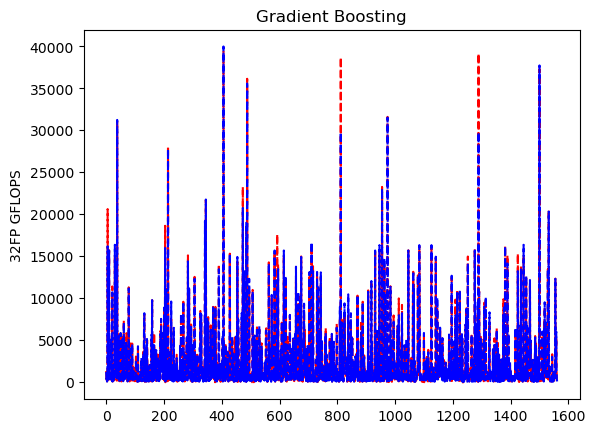

In [101]:
sns.lineplot(GB_grid.predict(X), color='red',linestyle='dashed')
sns.lineplot(y, color='blue',linestyle='dashed')

plt.ylabel('32FP GFLOPS')
plt.title('Gradient Boosting')
plt.show()

In [91]:
import pickle

pickle.dump( GB_grid.best_estimator_, open( "gbFinal.pkl", "wb" ) )


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


# Define the model

model = VotingRegressor(estimators=[('br', BaggingRegressor()), ('et', ExtraTreesRegressor()), ('xg', XGBRegressor())])

param_grid_voting = {
    'br__n_estimators': [10, 50, 100],
    'br__max_samples': [0.5, 0.7, 0.9],
    'br__max_features': [0.5, 0.7, 0.9],
    'et__n_estimators': [10, 50, 100],
    'et__max_depth': [None, 5, 10],
    'et__min_samples_split': [2, 5, 10],
    'et__min_samples_leaf': [1, 2, 4],
    'et__max_features': ['auto', 'sqrt', 'log2'],
    'xg__n_estimators': [10, 50, 100],
    'xg__learning_rate': [0.1, 0.01, 0.001],
    'xg__max_depth': [3, 5, 7],
    'xg__gamma': [0, 0.1, 0.5],
    'xg__reg_alpha': [0, 0.1, 1],
    'xg__reg_lambda': [0, 0.1, 1]
}

GB_grid = GridSearchCV(model, param_grid_voting, cv=5, refit=True, verbose=1, n_jobs=-1)

#fitting the grid search
GB_grid.fit(X_train, y_train)

#predicting the values
GB_grid_pred = GB_grid.predict(X_test)

#calculating the mean squared error
GB_grid_MAE = mean_absolute_error(y_test, GB_grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", GB_grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", GB_grid.best_params_)
GB_grid_MAE_train = mean_absolute_error(y_train, GB_grid.predict(X_train))
print('GB_grid_MAE_train: ', GB_grid_MAE_train)

Fitting 5 folds for each of 4782969 candidates, totalling 23914845 fits


KeyboardInterrupt: 

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Initial parameters
param_grid={
    'n_estimators': [10, 50, 100,150,200,250,300],
    'max_samples': [0.5, 0.7, 0.9,1.0,0.4,0.3,0.6],
    'max_features': [0.5, 0.7, 0.9,1.0,0.4,0.3,0.6],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}

#reduced parameters
# param_grid={ 
#     'n_estimators': [50],
#     'max_samples': [0.6,0.7,0.8],
#     'max_features': [0.9],
#     'bootstrap': [False],
#     'bootstrap_features': [True]
# }

#final parameters
# param_grid={
#     'n_estimators': [50],
#     'max_samples': [0.8],
#     'max_features': [0.9],
#     'bootstrap': [False],
#     'bootstrap_features': [True]
# }
kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
grid = GridSearchCV(BaggingRegressor(), param_grid,cv=kfolds, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

#predicting the values
grid_pred = grid.predict(X_test)

#calculating the mean squared error
grid_MAE = mean_absolute_error(y_test, grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", grid.best_params_)
grid_MAE_train = mean_absolute_error(y_train, grid.predict(X_train))
print('GB_grid_MAE_train: ', grid_MAE_train)

Fitting 10 folds for each of 1372 candidates, totalling 13720 fits
Gradient Boosting Grid Search MAE:  310.76652691812757
Gradient Boosting Grid Search Best Parameters:  {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}
GB_grid_MAE_train:  107.90175534305368


In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Initial parameters
# param_grid={
#     'n_estimators': [10, 50, 100,150,200,250,300],
#     'max_samples': [0.5, 0.7, 0.9,1.0,0.4,0.3,0.6],
#     'max_features': [0.5, 0.7, 0.9,1.0,0.4,0.3,0.6],
#     'bootstrap': [True, False],
#     'bootstrap_features': [True, False],
# }

#reduced parameters
param_grid={ 
    'n_estimators': [50],
    'max_samples': [0.6,0.7,0.8],
    'max_features': [0.9],
    'bootstrap': [False],
    'bootstrap_features': [True]
}

#final parameters
# param_grid={
#     'n_estimators': [50],
#     'max_samples': [0.8],
#     'max_features': [0.9],
#     'bootstrap': [False],
#     'bootstrap_features': [True]
# }
kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
grid = GridSearchCV(BaggingRegressor(), param_grid,cv=kfolds, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

#predicting the values
grid_pred = grid.predict(X_test)

#calculating the mean squared error
grid_MAE = mean_absolute_error(y_test, grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", grid.best_params_)
grid_MAE_train = mean_absolute_error(y_train, grid.predict(X_train))
print('GB_grid_MAE_train: ', grid_MAE_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Gradient Boosting Grid Search MAE:  326.54913514517466
Gradient Boosting Grid Search Best Parameters:  {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 50}
GB_grid_MAE_train:  138.7854149463447


In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Initial parameters
# param_grid={
#     'n_estimators': [10, 50, 100,150,200,250,300],
#     'max_samples': [0.5, 0.7, 0.9,1.0,0.4,0.3,0.6],
#     'max_features': [0.5, 0.7, 0.9,1.0,0.4,0.3,0.6],
#     'bootstrap': [True, False],
#     'bootstrap_features': [True, False],
# }

#reduced parameters
# param_grid={ 
#     'n_estimators': [50],
#     'max_samples': [0.6,0.7,0.8],
#     'max_features': [0.9],
#     'bootstrap': [False],
#     'bootstrap_features': [True]
# }

#final parameters
# # param_grid={
# #     'n_estimators': [50],
# #     'max_samples': [0.8],
# #     'max_features': [0.9],
# #     'bootstrap': [False],
# #     'bootstrap_features': [True]
# # }
# kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
grid = GridSearchCV(BaggingRegressor(), param_grid,cv=kfolds, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

#predicting the values
grid_pred = grid.predict(X_test)

#calculating the mean squared error
grid_MAE = mean_absolute_error(y_test, grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", grid.best_params_)
grid_MAE_train = mean_absolute_error(y_train, grid.predict(X_train))
print('GB_grid_MAE_train: ', grid_MAE_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Gradient Boosting Grid Search MAE:  296.81859247394027
Gradient Boosting Grid Search Best Parameters:  {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 50}
GB_grid_MAE_train:  85.96620567625261


In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

param_grid={
    'n_estimators': [10, 50, 100,150,200,250],
    'learning_rate': [0.1, 0.01, 0.001,0.2],
    'max_depth': [3, 5],
    'subsample': [0.5,0.6,0.4],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1,0.5, 1],
    'reg_lambda': [0, 0.1,0.5, 1],
}
kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
grid = GridSearchCV(XGBRegressor(), param_grid,cv=kfolds, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

#predicting the values
grid_pred = grid.predict(X_test)

#calculating the mean squared error
grid_MAE = mean_absolute_error(y_test, grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", grid.best_params_)
grid_MAE_train = mean_absolute_error(y_train, grid.predict(X_train))
print('GB_grid_MAE_train: ', grid_MAE_train)

Fitting 10 folds for each of 20736 candidates, totalling 207360 fits
Gradient Boosting Grid Search MSE:  348.5634966736816
Gradient Boosting Grid Search Best Parameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.4}
GB_grid_mse_train:  160.99982905228208


In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


# Define the model

model = VotingRegressor(estimators=[('br', BaggingRegressor()), ('xg', XGBRegressor())])

param_grid_voting = {
    'br__n_estimators': [300],
    'br__max_samples': [0.9],
    'br__max_features': [0.6],
    'xg__n_estimators': [250],
    'xg__learning_rate': [0.2],
    'xg__max_depth': [5],
    'xg__gamma': [0],
    'xg__reg_alpha': [1],
    'xg__reg_lambda': [0.5]
}
kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
VR_grid = GridSearchCV(model, param_grid_voting, cv=kfolds, refit=True, verbose=1, n_jobs=-1)

#fitting the grid search
VR_grid.fit(X_train, y_train)

#predicting the values
VR_grid_pred =VR_grid.predict(X_test)

#calculating the mean squared error
VR_grid_MAE = mean_absolute_error(y_test, VR_grid_pred)

#printing the MAE and best parameters
print("Gradient Boosting Grid Search MAE: ", VR_grid_MAE)
print("Gradient Boosting Grid Search Best Parameters: ", VR_grid.best_params_)
VR_grid_MAE_train = mean_absolute_error(y_train, VR_grid.predict(X_train))
print('GB_grid_MAE_train: ', VR_grid_MAE_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Gradient Boosting Grid Search MAE:  297.82844237793984
Gradient Boosting Grid Search Best Parameters:  {'br__max_features': 0.6, 'br__max_samples': 0.9, 'br__n_estimators': 300, 'xg__gamma': 0, 'xg__learning_rate': 0.2, 'xg__max_depth': 5, 'xg__n_estimators': 250, 'xg__reg_alpha': 1, 'xg__reg_lambda': 0.5}
GB_grid_MAE_train:  82.40597030318297


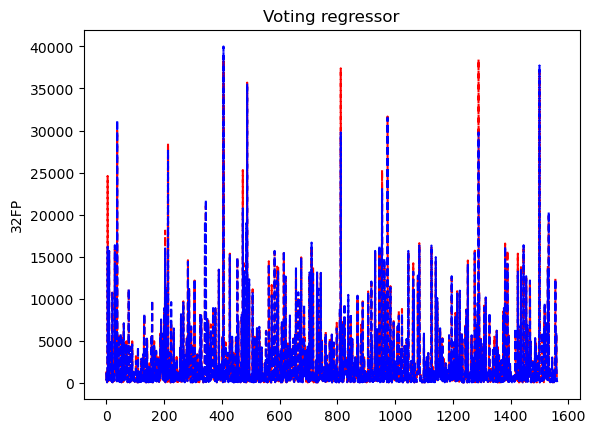

In [99]:
sns.lineplot(VR_grid.predict(X), color='red',linestyle='dashed')
sns.lineplot(y, color='blue',linestyle='dashed')

plt.ylabel('32FP')
plt.title('Voting regressor')
plt.show()

In [ ]:
import pickle

pickle.dump( GB_grid.best_estimator_, open( "voting.pkl", "wb" ) )


In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


# Define the model

model = LinearRegression()

param_grid_voting = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True]
}
kfolds = KFold(n_splits=10, shuffle=True, random_state=2202588)
LR_grid = GridSearchCV(model, param_grid_voting, cv=kfolds, refit=True, verbose=1, n_jobs=-1)

#fitting the grid search
LR_grid.fit(X_train, y_train)

#predicting the values
LR_grid_pred = LR_grid.predict(X_test)

#calculating the mean squared error
LR_grid_MAE = mean_absolute_error(y_test, LR_grid_pred)

#printing the MAE and best parameters
print("Linear Grid Search MAE: ", LR_grid_MAE)
print("Linear  Grid Search Best Parameters: ", LR_grid.best_params_)
LR_grid_MAE_train = mean_absolute_error(y_train, LR_grid.predict(X_train))
print('LR_grid_MAE_train: ', LR_grid_MAE_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Linear Grid Search MSE:  734.2780180265601
Linear  Grid Search Best Parameters:  {'copy_X': True, 'fit_intercept': True, 'positive': True}
LR_grid_mse_train:  739.6716974250063


c:\Users\Mingg\anaconda3\envs\INTMLDP\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Mingg\anaconda3\envs\INTMLDP\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
import pickle

pickle.dump( GB_grid.best_estimator_, open( "LR.pkl", "wb" ) )


c:\Users\Mingg\anaconda3\envs\INTMLDP\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


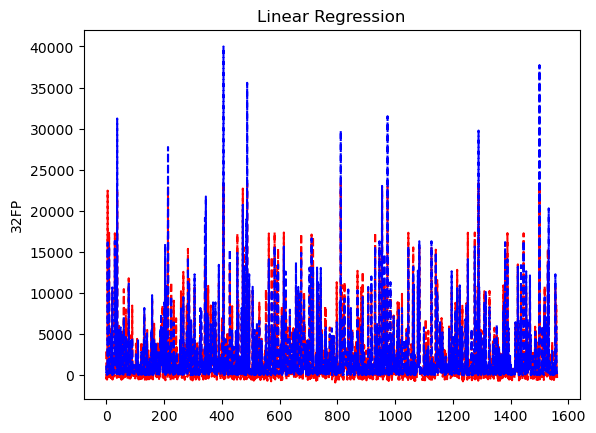

In [100]:
sns.lineplot(LR_grid.predict(X), color='red',linestyle='dashed')
sns.lineplot(y, color='blue',linestyle='dashed')

plt.ylabel('32FP')
plt.title('Linear Regression')
plt.show()